In [2]:
##if using django 3.0 set:

#import os
#os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")

##check:
#%env

In [1]:
import os
os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")

'true'

# Example of model fit, predict* and conversion to raster using API of antares3

*Prediction is object based.

**Will use an already ingested and processed Landsat8 data via antares3**

## Some imports

In [2]:
import sys
import os
import json

import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point
import rasterio
import dill
import geopandas as gpd
import fiona
from affine import Affine
from rasterio.features import rasterize

In [3]:
sys.__stdout__ = sys.stdout 

In [4]:
from datacube.api import GridWorkflow

from madmex.util.db import get_cmap_from_scheme
from madmex.models import Tag
from madmex.overlay.extractions import zonal_stats_xarray
from madmex.io.vector_db import VectorDb
from madmex.wrappers import gwf_query
from madmex.modeling.supervised.xgb import Model
from madmex.models import Tag
from madmex.overlay.extractions import zonal_stats_xarray
from madmex.util import randomword
from django.contrib.gis.geos.geometry import GEOSGeometry
from madmex.models import PredictObject

In [5]:
sys.stdout = sys.__stdout__

In [6]:
path = "/shared_volume/land_cover_results"

## Fit model

**Next will use an already product registered in the datacube DB. Query will also use region and date.**

In [7]:
name_of_product = 'recipe_chiapas_L8_17' #an already processed L8 data
region = 'Chiapas'
begin = '2017-01-01'
end = '2017-12-31'

gwf_kwargs = {'region': region, 
              'product': name_of_product, 
              'begin': begin, 
              'end':end}

**Query**

In [8]:
iterable = gwf_query(**gwf_kwargs)

**Sort list of results of query**

In [9]:
list_iter = list(iterable)

In [10]:
list_iter_sorted = sorted(list_iter, key = lambda x: (x[0][0], x[0][1]))

**Datacube tiles indexes:**

In [11]:
[index[0] for index in list_iter]

[(53, -39),
 (54, -39),
 (52, -38),
 (52, -39),
 (53, -38),
 (52, -40),
 (53, -37),
 (54, -37),
 (54, -38),
 (55, -38),
 (52, -37),
 (55, -39)]

**Select datacube tile index: (59, -31)**

In [13]:
tile = [index for index in list_iter_sorted if index[0] == (54, -38)][0]

In [14]:
tile

((54, -38),
 Tile<sources=<xarray.DataArray (time: 1)>
 array([(Dataset <id=1382945a-7bfe-5d1c-aab7-081d5beaf499 type=recipe_chiapas_L8_17 location=file://shared_volume/datacube_ingest/recipes/recipe_chiapas_L8_17/madmex_003_54_-38_2017-07-02.nc>,)],
       dtype=object)
 Coordinates:
   * time     (time) datetime64[ns] 2017-07-02,
 	geobox=GeoBox(1667, 1667, Affine(30.0, 0.0, 3677700.0,
        0.0, -30.0, 576350.0), PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS84",6378137,6556752.3141]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0]])>)

**Load via Grid Workflow API**

In [15]:
ds = GridWorkflow.load(tile[1])

**Print some info...**

In [16]:
ds

<xarray.Dataset>
Dimensions:     (time: 1, x: 1667, y: 1667)
Coordinates:
  * time        (time) datetime64[ns] 2017-07-02
  * y           (y) float64 5.763e+05 5.763e+05 ... 5.264e+05 5.264e+05
  * x           (x) float64 3.678e+06 3.678e+06 ... 3.728e+06 3.728e+06
Data variables:
    blue_mean   (time, y, x) int16 311 346 357 362 350 ... 318 315 320 338 381
    green_mean  (time, y, x) int16 636 672 680 667 620 ... 667 680 689 704 726
    red_mean    (time, y, x) int16 488 551 586 602 574 ... 653 645 651 662 707
    nir_mean    (time, y, x) int16 3729 3629 3443 3257 ... 3195 3236 3283 3447
    swir1_mean  (time, y, x) int16 2499 2674 2677 2688 ... 2122 2163 2322 2673
    swir2_mean  (time, y, x) int16 1209 1358 1420 1453 ... 1069 1086 1172 1390
    ndvi_mean   (time, y, x) int16 7628 7311 7026 6821 ... 6595 6604 6615 6551
    ndmi_mean   (time, y, x) int16 1965 1518 1251 950 ... 2040 1998 1733 1297
    ndvi_max    (time, y, x) int16 8459 8277 8203 8001 ... 7685 7583 7509 7721
    ndvi_min    (time, y, x) int16 5980 6065 5796 5567 ... 5105 5183 5303 4887
    ndmi_max    (time, y, x) int16 3581 3306 3412 2701 ... 3444 3388 2975 2605
    ndmi_min    (time, y, x) int16 -332 -520 -312 -515 -1254 ... -36 67 10 -928
    elevation   (time, y, x) int16 164 164 164 159 159 ... 160 160 160 156 156
    slope       (time, y, x) float32 1.6145442 1.6145442 ... 1.3702621 1.3702621
    aspect      (time, y, x) float32 73.30076 73.30076 ... 163.61046 163.61046
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...

**Visualize one band... e.g. `ndvi_mean`...**

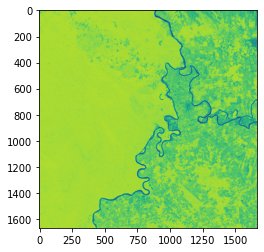

In [17]:
plt.imshow(ds.ndvi_mean[0,:,:])
plt.show()

**Load already registered training data in antares3 db...**

In [18]:
training_data = "train_chiapas_dummy"

In [19]:
loader = VectorDb()
fc_train_0 = loader.load_training_from_dataset(dataset=ds,
                                               training_set=training_data, 
                                               sample=1)

In [20]:
# Evaluate the generator (safe to do here since the data is not huge)
fc_train_0 = list(fc_train_0)

In [21]:
len(fc_train_0)

816

In [22]:
fc_train_0[0]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[3681887.503196632, 526534.3451950208],
    [3681887.383999407, 526531.8803127464],
    [3681887.025237519, 526529.4392840322],
    [3681886.43036604, 526527.0456173257],
    [3681885.6051139077, 526524.7223649459],
    [3681884.5574287516, 526522.4919010838],
    [3681883.2974003493, 526520.3757063197],
    [3681881.837163466, 526518.3941607715],
    [3681880.1907809773, 526516.5663478025],
    [3681878.3741084514, 526514.9098702591],
    [3681876.404641433, 526513.4406809291],
    [3681874.3013469717, 526512.172928891],
    [3681872.0844809376, 526511.1188233017],
    [3681869.77539297, 526510.2885157807],
    [3681867.39632084, 526509.690002631],
    [3681864.970176321, 526509.329047876],
    [3681862.5203245077, 526509.2091276909],
    [3681860.070358816, 526509.3313969867],
    [3681857.6438737498, 526509.6946782353],
    [3681855.264237693, 526510.2954728394],
    [3681852.9543678407, 526511.1279948216],
    

**Assign code level to this training data according to next scheme..**

In [23]:
scheme = "madmex"

In [24]:
qs = Tag.objects.filter(scheme=scheme)
tag_mapping = {x.id:x.numeric_code for x in qs}
tag_id_list = [x['properties']['class'] for x in fc_train_0]


In [25]:
fc_train = [{'geometry': x[0]['geometry'],
             'properties': {'code': tag_mapping[x[1]]},
             'type': 'feature'} for x in zip(fc_train_0, tag_id_list)]

In [26]:
fc_train[0]

{'geometry': {'type': 'Polygon',
  'coordinates': [[[3681887.503196632, 526534.3451950208],
    [3681887.383999407, 526531.8803127464],
    [3681887.025237519, 526529.4392840322],
    [3681886.43036604, 526527.0456173257],
    [3681885.6051139077, 526524.7223649459],
    [3681884.5574287516, 526522.4919010838],
    [3681883.2974003493, 526520.3757063197],
    [3681881.837163466, 526518.3941607715],
    [3681880.1907809773, 526516.5663478025],
    [3681878.3741084514, 526514.9098702591],
    [3681876.404641433, 526513.4406809291],
    [3681874.3013469717, 526512.172928891],
    [3681872.0844809376, 526511.1188233017],
    [3681869.77539297, 526510.2885157807],
    [3681867.39632084, 526509.690002631],
    [3681864.970176321, 526509.329047876],
    [3681862.5203245077, 526509.2091276909],
    [3681860.070358816, 526509.3313969867],
    [3681857.6438737498, 526509.6946782353],
    [3681855.264237693, 526510.2954728394],
    [3681852.9543678407, 526511.1279948216],
    [3681850.736509504, 

In [29]:
gdf_from_features = gpd.GeoDataFrame.from_features(fc_train)

In [30]:
gdf_from_features.head()

,geometry,code
0,"POLYGON ((3681887.503 526534.345, 3681887.384 ...",9
1,"POLYGON ((3689298.439 576581.754, 3689298.320 ...",9
2,"POLYGON ((3697193.891 553722.536, 3697193.771 ...",9
3,"POLYGON ((3684487.767 541266.702, 3684487.648 ...",9
4,"POLYGON ((3686030.800 563613.022, 3686030.681 ...",9


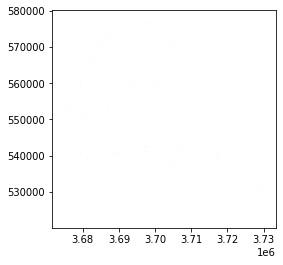

In [41]:
gdf_from_features.plot()
plt.show()

In [42]:
# copy GeoDataFrame
points = gdf_from_features.copy()

In [43]:
# change geometry 
points['geometry'] = points['geometry'].centroid
points.head()

,geometry,code
0,POINT (3681862.508 526534.357),9
1,POINT (3689273.445 576581.766),9
2,POINT (3697168.896 553722.548),9
3,POINT (3684462.772 541266.714),9
4,POINT (3686005.806 563613.034),9


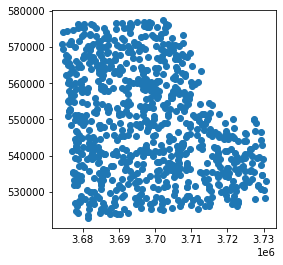

In [44]:
points.plot()
plt.show()

In [45]:
len(points['code'].unique())

7

In [46]:
gdf_from_features.total_bounds

array([3674284.23292159,  522746.83834372, 3730674.58697177,
        577420.07594424])

In [47]:
points.total_bounds

array([3674309.22716276,  522771.98648486, 3730649.59222433,
        577394.92912567])

In [48]:
crs_dict = {'proj': 'lcc',
            'lat_1': 17.5,
            'lat_2': 29.5,
            'lat_0': 12,
            'lon_0': -102,
            'x_0': 2500000,
            'y_0': 0,
            'datum': 'WGS84',
            'units': 'm',
            'no_defs': True,
            'a':6378137,
            'b':6378136.027241431,
            'wktext': True}

In [49]:
gdf_from_features.crs

In [50]:
gdf_from_features.crs = crs_dict

In [53]:
points.crs = crs_dict

**Extract some zonal statistics using dataset and feature collection of training data...**

In [55]:
X_train, y_train = zonal_stats_xarray(ds, fc_train, 'code')

In [56]:
X_train

array([[203.5       , 464.5       , 238.5       , ..., 162.        ,
          1.31687391,  86.63353729],
       [171.        , 389.5       , 224.        , ..., 190.        ,
          5.99785328, 222.91743469],
       [200.        , 418.        , 246.        , ..., 210.        ,
          1.42164409, 225.        ],
       ...,
       [211.33333333, 426.66666667, 258.33333333, ..., 132.        ,
          0.91864878,  45.03708649],
       [210.5       , 439.5       , 244.5       , ..., 134.        ,
          0.99037647, 128.6598053 ],
       [227.        , 461.        , 248.        , ..., 138.5       ,
          0.7810412 , 174.34503174]])

In [57]:
X_train.shape

(720, 15)

In [58]:
y_train

array([ 9,  9,  9,  9, 28, 28,  9,  9,  9, 27,  9, 27, 27,  9,  9, 28,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 28, 28, 28,  9,  9, 28,
        9, 28,  9,  9,  9,  9,  9,  9, 27, 28, 27,  9,  9, 22, 22, 27, 28,
        9,  9, 28,  9, 27, 27,  9, 28,  9,  9, 28,  9,  9, 28,  9,  9, 27,
       28,  9, 27, 28, 22, 31,  9,  9, 28,  9, 27,  9,  9,  9, 28, 27, 27,
        9, 28,  9,  9,  9,  9,  9,  9,  9,  9,  9, 28,  9,  9,  9,  9,  9,
       31, 28, 28,  9, 28, 28,  9, 28, 28, 28,  9,  9, 28,  9,  9,  9, 28,
        9, 27,  9,  9,  9, 28,  9,  9,  9,  9,  9,  9, 28,  9,  9, 28, 28,
        9, 28,  9,  9,  9,  9,  9,  9,  9, 28, 28,  9,  9,  9, 28,  9,  9,
       28,  9, 22, 28, 27,  9,  9,  9,  9,  9, 22, 28,  9, 28, 28,  9, 27,
       28,  9, 28,  9,  9,  9, 28,  9,  9,  9,  9,  9,  9, 27,  9,  9, 31,
        9,  9,  9,  9,  9,  9,  9, 27, 27, 28,  9,  9,  9, 28,  9,  9, 28,
        9,  9,  9,  9, 28, 28,  9,  9,  9,  9, 28,  9,  9,  9, 28,  9,  9,
        9,  9,  9,  9, 28

**Model fit: xgboost..**

In [59]:
xgb_model = Model()

In [60]:
xgb_model.fit(X_train, y_train)

**Write model to filesystem (just to load it if this notebook crashes or kernel is reloaded in the future...) ...**

In [61]:
path

'/shared_volume/land_cover_results'

In [64]:
name_model = 'model_landsat8_chiapas_2017_madmex_31_clases' + '_%d_%d' %(tile[0][0],tile[0][1])
filename_model = '%s_%s.pkl' % (name_model, randomword(5))
filepath_model = os.path.join(path, filename_model)

In [65]:
filepath_model

'/shared_volume/land_cover_results/model_landsat8_chiapas_2017_madmex_31_clases_54_-38_vxdef.pkl'

In [66]:
with open(filepath_model, 'wb') as dst:
    dill.dump(xgb_model, dst)

## Predict object based

## Load segmentation

In [72]:
seg_name = 'seg_chiapas_L8_17'

In [73]:
geom = GEOSGeometry(json.dumps(ds.geobox.geographic_extent.json))
qs = PredictObject.objects.filter(the_geom__contained=geom,segmentation_information__name=seg_name)
path_seg = qs[0].path

In [74]:
path_seg

'/shared_volume/segmentation/slic_seg_chiapas_L8_17_landsat8_54_-38_2017.shp'

**Predict**

In [77]:
with fiona.open(path_seg) as src:
    X_pred, _ = zonal_stats_xarray(ds, src, 'id')
    y_pred = xgb_model.predict(X_pred)
    fc_pred = [(x[0]['geometry'], x[1]) for x in zip(src, y_pred)]
    source_driver = src.driver
    source_crs = src.crs
    source_schema = src.schema

In [78]:
X_pred

array([[274.12673611, 661.21006944, 491.72222222, ..., 172.47916667,
          3.76120543, 144.71194458],
       [239.80729167, 543.38020833, 335.85069444, ..., 200.00520833,
          6.60368109, 211.06695557],
       [201.78125   , 488.296875  , 291.8125    , ..., 212.52604167,
          7.39388752, 238.1703949 ],
       ...,
       [361.5521978 , 694.45604396, 633.46291209, ..., 162.07142857,
          1.7761215 , 154.59822083],
       [334.98840206, 717.64046392, 628.47680412, ..., 156.21391753,
          1.58060408, 151.75968933],
       [345.29224905, 692.63786531, 623.94409149, ..., 160.59085133,
          1.91554034,  16.50127602]])

In [79]:
y_pred

array([27, 27,  9, ..., 28, 28, 28])

In [81]:
np.unique(y_pred)

array([ 9, 22, 27, 28, 29, 30, 31])

In [82]:
fc_pred[0]

({'type': 'Polygon',
  'coordinates': [[(3677700.0, 576350.0),
    (3678420.0, 576350.0),
    (3678420.0, 575630.0),
    (3677700.0, 575630.0),
    (3677700.0, 576350.0)]]},
 27)

In [83]:
fc_schema = {'geometry': 'Polygon',
         'properties': {'code': 'int'}}
fc_pred_geojson = [{'geometry': x[0],
                  'properties': {'code': int(x[1])}, #why is necessary to transform to int ???
                  'type': 'feature'} for x in fc_pred]

In [84]:
fc_pred_geojson[0]

{'geometry': {'type': 'Polygon',
  'coordinates': [[(3677700.0, 576350.0),
    (3678420.0, 576350.0),
    (3678420.0, 575630.0),
    (3677700.0, 575630.0),
    (3677700.0, 576350.0)]]},
 'properties': {'code': 27},
 'type': 'feature'}

In [85]:
gdf_pred = gpd.GeoDataFrame.from_features([feature for feature in fc_pred_geojson], 
                                          crs = crs_dict)

In [86]:
gdf_pred.head()

,geometry,code
0,"POLYGON ((3677700.000 576350.000, 3678420.000 ...",27
1,"POLYGON ((3678420.000 576350.000, 3679140.000 ...",27
2,"POLYGON ((3679140.000 576350.000, 3679860.000 ...",9
3,"POLYGON ((3679860.000 576350.000, 3680580.000 ...",9
4,"POLYGON ((3680580.000 576350.000, 3681300.000 ...",9


In [87]:
bbox = gdf_pred.total_bounds

In [88]:
bbox

array([3677700.,  526340., 3727710.,  576350.])

In [91]:
p1 = Point(bbox[0], bbox[3])
p2 = Point(bbox[2], bbox[3])
p3 = Point(bbox[2], bbox[1])
p4 = Point(bbox[0], bbox[1])

In [92]:
x_min, x_max = p1.coords.xy[0][0], p3.coords.xy[0][0]
y_min, y_max = p3.coords.xy[1][0], p1.coords.xy[1][0]

In [93]:
x_min, x_max

(3677700.0, 3727710.0)

In [94]:
y_min, y_max

(526340.0, 576350.0)

In [96]:
resolution=30

In [97]:
nrows = int(((y_max - y_min) // resolution) + 1)
ncols = int(((x_max - x_min) // resolution) + 1)
shape_dim = (nrows, ncols)

In [98]:
shape_dim

(1668, 1668)

**Write array to geotiff in filesystem**

In [103]:
filename_raster = os.path.join(path,'raster_landsat8_chiapas_madmex_31_clases' + '_%d_%d' %(tile[0][0],tile[0][1]) + '.tif')

In [104]:
filename_raster

'/shared_volume/land_cover_results/raster_landsat8_chiapas_madmex_31_clases_54_-38.tif'

In [107]:
arr = np.zeros((nrows, ncols), dtype=np.uint8)
aff = Affine(resolution, 0, x_min, 0, -resolution, y_max)

In [111]:
rasterize(shapes=fc_pred, transform=aff, dtype=np.uint8, out=arr)


array([[27, 27, 27, ..., 28, 28,  0],
       [27, 27, 27, ..., 28, 28,  0],
       [27, 27, 27, ..., 28, 28,  0],
       ...,
       [ 9,  9,  9, ..., 28, 28,  0],
       [ 9,  9,  9, ..., 28, 28,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [112]:
meta = {'driver': 'GTiff',
        'width': shape_dim[1],
        'height': shape_dim[0],
        'count': 1,
        'dtype': arr.dtype,
        'crs': crs_dict,
        'transform': aff,
        'compress': 'lzw',
        'nodata': 0}

In [113]:
with rasterio.open(filename_raster, 'w', **meta) as dst:
    dst.write(arr, 1)

## What is missing is create mapping in db for:

**Just as a reference:**

dic_values = {1: 'Bosques de aciculifolias y escuamifolias',
              2: 'Bosques latifoliados',
              3: 'Bosque húmedo de montaña',
              4: 'Manglar y petén',
              5: 'Selvas húmedas',
              6: 'Selvas secas',
              7: 'Matorral alto denso',
              8: 'Matorral mésico',
              9: 'Matorral bajo abierto',
              10: 'Vegetación acuática menor',
              11: 'Vegetación de suelos arenosos',
              12: 'Vegetación halófila',
              13: 'Pastizales y otra vegetación herbácea',
              14: 'Tierras agrícolas',
              15: 'Urbano y construido',
              16: 'Suelo desnudo',
              17: 'Agua'}

dic_colors={1:'#005100',
            2:'#007e00',
            3:'#00d900',
            4:'#55aaff',
            5:'#ff007f',
            6:'#ff55ff',
            7:'#6d4724',
            8:'#ffb265',
            9:'#aa8000',
            10:'#aaffff',
            11:'#a2ecb1',
            12:'#00aa7f',
            13:'#e9e9af',
            14:'#faff98',
            15:'#4d1009',
            16:'#c7c8bc',
            17:'#00007f'}

**Add color map to file that will be written in filesystem like in:**

https://github.com/CONABIO/antares3-sandbox/blob/master/notebooks/forests_maps_julian/model_predict_and_db_to_raster_pipeline.ipynb